In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from mpmath import mp, matrix, eye
import math

In [17]:
def set_precision(dps):
    mp.dps = dps

def rand_matrix(n: int, scale: float = 1.0):
    return matrix([[mp.rand() * scale for _ in range(n)] for _ in range(n)])

def symmetrize(A):
    return (A + A.T) * mp.mpf('0.5')

def eigh_mp(A):
    vals, vecs = mp.eigh(A)
    Q = matrix(vecs)
    lam = list(vals)
    return Q, lam

def project_onto_A(A, tol=None):
    
    Q, lam = eigh_mp(A)
    if tol is None:
        tol = mp.mpf('0')
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im else
            (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
            for lv in lam]
    lam_clipped = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    n = A.rows
    D = matrix(n)
    for i, v in enumerate(lam_clipped):
        D[i, i] = v
    return Q * D * Q.T

def project_onto_B(A):
    S = symmetrize(A)
    n = S.rows
    for i in range(n):
        S[i, i] = mp.mpf('1')
    return S

def fro_norm(A):
    return mp.sqrt(mp.fsum(A[i, j]**2 for i in range(A.rows) for j in range(A.cols)))

def is_psd(A, tol=mp.mpf('0')):
    """
    Return (ok, lam_min) where:
      ok       : True iff λ_min(A_sym) >= -tol
      lam_min  : smallest eigenvalue of the symmetrized matrix
    tol = 0 enforces the exact (theoretical) PSD test; increase tol to be pragmatic.
    """
    vals, _ = mp.eigh(A)          # real for symmetric S
    lam_min = min(vals)
    return (lam_min >= -tol), lam_min

def is_psd_boundary(A, tol=mp.mpf('0')):
    """
    Return (ok, lam_min) where:
      ok       : True iff A is PSD and λ_min(A) is (numerically) zero,
      lam_min  : smallest eigenvalue of the symmetrized matrix.
    tol = 0 enforces the exact (theoretical) boundary test; increase tol
    to allow for numerical tolerance.
    """

    vals, _ = mp.eigh(A)
    lam_min = min(vals)

    # PSD if all eigenvalues >= -tol
    psd = all(lv >= -tol for lv in vals)

    # On the boundary if PSD and min eigenvalue is within tol of 0
    on_boundary = psd and abs(lam_min) <= tol

    return on_boundary, lam_min


def is_S1(A, tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check if A is (approximately) symmetric with diag=1.
    """
    sym_err  = fro_norm(A - A.T) * mp.mpf('0.5')     # = ||skew(A)||_F
    if A.rows > 0:
        diag_err = max(abs(A[i,i] - mp.mpf('1')) for i in range(A.rows))
    else:
        diag_err = mp.mpf('0')
    ok = (sym_err <= tol_sym) and (diag_err <= tol_diag)
    return ok, {'sym_err': sym_err, 'diag_err': diag_err}

def is_S11(A, tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check if A is approximately symmetric (within tol_sym)
    and satisfies X[0,0] = 1 (within tol_diag).
    """
    sym_err = fro_norm(A - A.T)           # uses your existing fro_norm
    x11_err = abs(A[0, 0] - mp.mpf('1')) if A.rows and A.cols else mp.mpf('0')

    ok = (sym_err <= tol_sym) and (x11_err <= tol_diag)
    return ok, {'sym_err': sym_err, 'x11_err': x11_err}




def is_feasible_setting1(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSD and in S1 (symmetric + diag=1).
    """
    ok_psd, lam_min = is_psd(A, tol=tol_psd)
    ok_s1, d        = is_S1(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def is_feasible_setting2(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSDb and in S1 (symmetric + diag=1).
    """
    ok_psd, lam_min = is_psd_boundary(A, tol=tol_psd)
    ok_s1, d        = is_S1(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def is_feasible_setting3(A, tol_psd=mp.mpf('0'), tol_sym=mp.mpf('0'), tol_diag=mp.mpf('0')):
    """
    Check feasibility: PSDb and in S1 (symmetric + entry1=1).
    """
    ok_psd, lam_min = is_psd_boundary(A, tol=tol_psd)
    ok_s1, d        = is_S11(A, tol_sym=tol_sym, tol_diag=tol_diag)
    ok = ok_psd and ok_s1
    diags = {'lam_min': lam_min, **d}
    return ok, diags

def vec_inner(u, v):
    """Inner product <u,v> treating matrices as flattened vectors."""
    return mp.fsum(u[i,j]*v[i,j] for i in range(u.rows) for j in range(u.cols))

def vec_norm2(u):
    """Squared Frobenius norm."""
    return mp.fsum(u[i,j]**2 for i in range(u.rows) for j in range(u.cols))


In [3]:
def project_onto_A(A, tol=None):
    # Eigendecomposition (assumes A is Hermitian / symmetric)
    Q, lam = eigh_mp(A)

    # Tolerances (use exact mpf types)
    if tol is None:
        tol = mp.mpf('0')              # treat exact zeros as semidefinite
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check

    # Real-part extraction with sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im
                else (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
                for lv in lam]

    # If any eigenvalue is <= tol, do standard PSD clipping; else (PD) push to boundary
    if any(lv <= tol for lv in lam_real):
        lam_mod = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    else:
        # Already PD: zero the smallest eigenvalue (force rank drop)
        k_min = min(range(len(lam_real)), key=lambda i: lam_real[i])
        lam_mod = lam_real[:]
        lam_mod[k_min] = mp.mpf('0')
    # Reassemble
    D = matrix(len(lam_mod))
    for i, v in enumerate(lam_mod):
        D[i, i] = v

    # If A is real-symmetric, Q.T is fine; for complex Hermitian, use Q.conjugate().T
    return Q * D * Q.T

In [4]:
def project_onto_B(A):
    S = symmetrize(A)
    S[0, 0] = mp.mpf('1')
    return S

In [5]:
def douglas_rachford(M, max_iterates, ignore_tol=False, tol_stop=mp.mpf('1e-6')):
    """
    High-precision Douglas–Rachford using existing project_onto_A and project_onto_B.
    
    Args:
        M            : starting matrix (mpmath.matrix)
        max_iterates : maximum number of iterations
        ignore_tol   : if True, ignore stopping tolerance
        tol_stop     : tolerance for stopping based on successive P_B iterates
        
    Returns:
        (last_proj, tol, iters, Xi, Proj_Xi)
    """
    Xi = [M]
    Proj_Xi = [project_onto_B(M)]
    iterates = 0
    
    while iterates < max_iterates:
        Xk = Xi[-1]

        PB = project_onto_B(Xk)
        RB = PB*2 - Xk

        PARB = project_onto_A(RB)
        RARB = PARB*2 - RB

        # relaxation 1/2: X_{k+1} = 0.5*R_A R_B X_k + 0.5*X_k
        X_next = (RARB + Xk) * mp.mpf('0.5')
        Xi.append(X_next)

        PB_next = project_onto_B(X_next)
        Proj_Xi.append(PB_next)

        iterates += 1
        tol = fro_norm(PB_next - Proj_Xi[-2])

        if (not ignore_tol) and (tol < tol_stop):
            break
    
    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [6]:
def TTx(M):
    """
    Do two Douglas–Rachford updates in high precision (mpmath).
    Returns the initial matrix and the next two iterates.
    """
    Xi = [M]  # initial point
    for _ in range(2):
        PB   = project_onto_B(Xi[-1])
        RB   = PB*2 - Xi[-1]
        PARB = project_onto_A(RB)
        RARB = PARB*2 - RB
        T    = (RARB + Xi[-1]) * mp.mpf('0.5')   # high-precision 1/2
        Xi.append(T)
    return Xi[0], Xi[1], Xi[2]


In [19]:
def lyapunov_surrogate(x, max_iterates, ignore_tol=False):
    iterates = 0
    Xi = [x]
    Proj_Xi = [project_onto_B(x)]

    stopping_threshold = mp.mpf('1e-6') if not ignore_tol else mp.mpf('1e-30')
    iterate_increment  = 2 if not ignore_tol else 1

    while iterates < max_iterates:
        ttx = TTx(Xi[-1])   # returns (x, T(x), TT(x))
        w1  = ttx[1] - ttx[0]
        w2  = ttx[2] - ttx[0]

        w1_norm_sq = vec_norm2(w1)
        w2_norm_sq = vec_norm2(w2)
        product    = vec_inner(w1, w2)

        # Fixed point test
        if fro_norm(w2) < mp.mpf('1e-15') and not ignore_tol:
            Xi.append(ttx[2])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ttx[2]-ttx[1])
            iterates += iterate_increment
            break
        
        if fro_norm(w2) == mp.mpf('0') and ignore_tol:
            Xi.append(ttx[1])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += 1
            #print("dr update: denominator is zero")
            continue
        
        collinear = mp.mpf('1') - (product**2) / (w1_norm_sq * w2_norm_sq)

        if collinear > mp.mpf('1e-15') or ignore_tol:
            # Matrix and vector for mu
            Mmat = matrix([
                [w2_norm_sq, -product],
                [-product,   w1_norm_sq]
            ])
            Vvec = matrix([
                [w1_norm_sq],
                [w2_norm_sq - product + w1_norm_sq]
            ])
            denom = w1_norm_sq * w2_norm_sq - product**2
            #print("LT denom is:", denom)
            if denom == mp.mpf('0'):
                Xi.append(ttx[1])
                Proj_Xi.append(project_onto_B(Xi[-1]))
                tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
                iterates += 1
                #print("dr update: denominator is zero")
                continue
            mu    = (mp.mpf('1')/denom) * (Mmat * Vvec)

            # LT step
            LT = ttx[0] + mu[0] * w1 + mu[1] * w2
            Xi.append(LT)
            Proj_Xi.append(project_onto_B(Xi[-1]))

            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += iterate_increment
            #print("lt update")
            if tol < stopping_threshold and not ignore_tol:
                break
        else:
            # Collinear points → just T(x)
            Xi.append(ttx[1])
            Proj_Xi.append(project_onto_B(Xi[-1]))
            #print("dr update, collinear")
            tol = fro_norm(Proj_Xi[-1]-Proj_Xi[-2])
            iterates += 1

            if tol < stopping_threshold and not ignore_tol:
                break

    return Proj_Xi[-1], tol, iterates, Xi, Proj_Xi


In [20]:
def projected_lyapunov_surrogate(x, max_iterates, ignore_tol=False,
                                 tol_threshold=mp.mpf('1e-6')):
    """
    mpmath-precision 'projected' Lyapunov Surrogate:
      - maintains both P_A(X_k) and P_B(X_k)
      - uses TTx on the latest A-projection

    Assumes the following are already defined for mpmath.matrices:
      project_onto_A, project_onto_B, TTx
    """
    

    stopping_threshold = (tol_threshold if not ignore_tol else mp.mpf('1e-40'))
    iterate_increment  = (2 if not ignore_tol else 1)

    iterates = 0
    Xi      = [x]
    ProjB   = [project_onto_B(x)]  # P_A(X_0)
    ProjA   = [project_onto_B(x)]  # P_B(X_0)

    while iterates < max_iterates:
        # Use TTx on the latest A-projection (as per your docstring)
        XA         = ProjA[-1]
        x0, x1, x2 = TTx(XA)  # all mpmath.matrices

        # w1 = T(x) - x, w2 = TT(x) - x
        w1 = x1 - x0
        w2 = x2 - x0

        # norms / inner products
        w1_ns = vec_norm2(w1)              # ||w1||_F^2
        w2_ns = vec_norm2(w2)              # ||w2||_F^2
        prod  = vec_inner(w1, w2)          # <w1, w2>_F

        # fixed-point checks on w2
        norm_w2 = fro_norm(w2)
        if (not ignore_tol and norm_w2 < mp.mpf('1e-15')):
            Xi.append(x2)
            ProjA.append(project_onto_B(Xi[-1]))
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(x2 - x1)
            iterates += iterate_increment
            #print("dr update: denominator is zero")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break
            continue
        
        if norm_w2 == mp.mpf('0') and ignore_tol:
            Xi.append(x1)
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ProjB[-1]-ProjB[-2])
            iterates += 1
            #print("dr update: denominator is zero")
            continue

        # Collinearity measure: 1 - (prod^2)/(||w1||^2 ||w2||^2)
        collinear = mp.mpf('1') - (prod*prod) / (w1_ns * w2_ns)

        if collinear > mp.mpf('1e-15') or ignore_tol:
            # Closed-form 2x2 solve for (mu1, mu2)
            a   = w2_ns
            b   = w1_ns
            c   = prod
            den = a*b - c*c
            #print("PLT denom is:", den)
            if den == mp.mpf('0'):
                Xi.append(x1)
                ProjB.append(project_onto_B(Xi[-1]))
                tol = fro_norm(ProjB[-1]-ProjB[-2])
                iterates += 1
                print("dr update: denominator is zero")
                continue
            v1  = b
            v2  = (a - c + b)
            mu1 = (a*v1 + (-c)*v2) / den
            mu2 = ((-c)*v1 + b*v2) / den

            # LT = x + mu1*w1 + mu2*w2
            LT = x0 + mu1*w1 + mu2*w2

            Xi.append(LT)
            ProjA.append(project_onto_B(LT))
            ProjB.append(project_onto_B(LT))

            tol = fro_norm(ProjA[-1] - ProjA[-2])   # stopping on A-shadow
            iterates += iterate_increment
            #print("plt update")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break
        else:
            # Collinear → take T(x)
            Xi.append(x1)
            ProjA.append(project_onto_B(Xi[-1]))
            ProjB.append(project_onto_B(Xi[-1]))
            tol = fro_norm(ProjA[-1] - ProjA[-2])   # stopping on A-shadow
            iterates += 1
            #print("dr update: collinear")
            if (not ignore_tol) and (tol <= stopping_threshold):
                break

    # Return: P_A(last), tol, iter count, raw iterates, A-shadow sequence
    return ProjA[-1], tol, iterates, Xi, ProjA


In [9]:
def count_true(lst):
    return sum(1 for item in lst if item)

In [10]:
def uniform01_fixed(rng, bits=64):
    # exact rational in [0,1)
    num = rng.getrandbits(bits)
    den = 1 << bits
    return mp.mpf(num) / den  # value is independent of mp.dps

def uniform_ab(rng, a, b, bits=64):
    u = uniform01_fixed(rng, bits)
    return a + (b - a) * u


def rand_matrix_fixed(n, rng, a=-1, b=1, bits=64):
    M = matrix(n, n)
    for i in range(n):
        for j in range(n):
            M[i, j] = uniform_ab(rng, a, b, bits)
    return M



In [11]:
precision=300
set_precision(precision)
master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 10
n   = 2
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
M_list[0]

matrix(
[['0.6045301188004360246985081256570440523483665519045405589526966598850273732993431701127941269025001247428008355200290679931640625', '-0.40983605880649758187571670457502657506819471223697638530722275536523017279123159672103195172443435012610279954969882965087890625'],
 ['-0.40983605880649758187571670457502657506819471223697638530722275536523017279123159672103195172443435012610279954969882965087890625', '-0.5800903822347878689030705744512932189634221351806010043737648239265478820376841420495585277539163371329777874052524566650390625']])

In [12]:
def round_matrix(M, ndigits=None, tol_im=None):
    """
    Convert an mpmath matrix (possibly complex) to a NumPy float64 array.
    - Checks imaginary parts against tol_im, then discards them.
    - Optional decimal rounding via Python's round (post float conversion).
    """
    if tol_im is None:
        tol_im = mp.mpf(f'1e-{mp.dps//2}')  # precision-aware default

    rows, cols = M.rows, M.cols
    A = np.empty((rows, cols), dtype=np.float64)

    for i in range(rows):
        for j in range(cols):
            v = M[i, j]
            re, im = mp.re(v), mp.im(v)
            if abs(im) > tol_im:
                raise ValueError(f"Unexpected imaginary part at ({i},{j}): {im}")
            x = float(re)  # may lose precision if re is very large/small
            if ndigits is not None:
                x = round(x, ndigits)
            A[i, j] = x
    return A

def round_vector(v, ndigits=6, tol=None):
    """Convert list/tuple of mpc/mpf values to rounded mpf with imag discarded."""
    if tol is None:
        tol = mp.eps * 10
    out = []
    for x in v:
        re, im = mp.re(x), mp.im(x)
        if abs(im) > tol:
            raise ValueError(f"Unexpected imaginary part: {im}")
        out.append(mp.mpf(mp.nstr(re, n=ndigits)))
    return out

# Example usage
rounded = round_matrix(project_onto_A(M), ndigits=6)

mp.mpf(f'1e-{mp.dps}')
print(rounded)


[[ 0.718352 -0.106409]
 [-0.106409  0.015762]]


In [30]:
precision=500
set_precision(precision)

def project_onto_A(A, tol=None):
    
    Q, lam = eigh_mp(A)
    if tol is None:
        tol = mp.mpf('0')
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im else
            (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
            for lv in lam]
    lam_clipped = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    n = A.rows
    D = matrix(n)
    for i, v in enumerate(lam_clipped):
        D[i, i] = v
    return Q * D * Q.T

def project_onto_B(A):
    S = symmetrize(A)
    n = S.rows
    for i in range(n):
        S[i, i] = mp.mpf('1')
    return S

def calculate_log_norms(iterates, threshold=None):
    """
    High-precision: return [ log10(||x_i - x_*||_F) ] for i = 1..k-1.
    Each entry is mp.mpf (or None if the norm is zero or below cutoff).
    threshold: cutoff on log10(norm); default ~half of working digits.
    """
    if len(iterates) < 2:
        return []

    if threshold is None:
        threshold = mp.mpf(-(mp.dps // 2))  # precision-aware cutoff

    xk = iterates[-1]
    out = []
    for xi in iterates[:-1]:
        n = fro_norm(xi - xk)  # mp.mpf >= 0
        if n == mp.mpf('0'):
            out.append(None)
        else:
            lg10 = mp.log10(n)  # exact base-10, no division by ln(10)
            out.append(lg10 if lg10 > threshold else None)
    return out




master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 1000
n   = 10
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
x0=M_list[0]
# can get quadratic lt linear plt if n=10, a=-4,b=4 bound psd and s11

runs = 10
iterates_set1 = douglas_rachford(x0, runs, True)[3]
iterates_set2 = lyapunov_surrogate(x0, runs, True)[3]
iterates_set3 = projected_lyapunov_surrogate(x0, runs, True)[3]

log_norms_set1 = calculate_log_norms(iterates_set1)
log_norms_set2 = calculate_log_norms(iterates_set2)
log_norms_set3 = calculate_log_norms(iterates_set3)


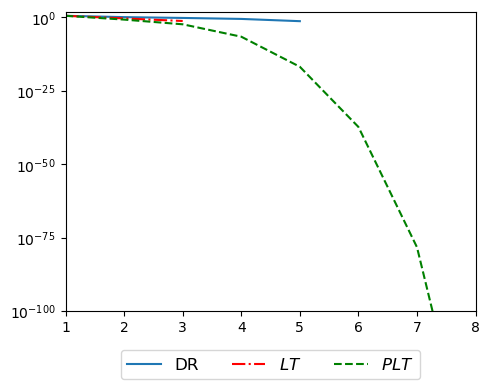

In [31]:
# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1)+1), log_norms_set1,  label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), log_norms_set2,  label='$LT$',  linestyle='-.', color='red')
plt.plot(range(1, len(log_norms_set3) + 1), log_norms_set3,  label='$PLT$', color='green', linestyle= '--')
plt.grid(False)
plt.ylim(-100,2)
plt.xlim(1, 8)

# Set y-ticks as powers of 10
ax = plt.gca()
ax.set_yticks([-100, -75, -50, -25, 0])
ax.set_yticklabels([r'$10^{-100}$', r'$10^{-75}$', r'$10^{-50}$', r'$10^{-25}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=12
)

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('B,A, psd and s1, n=10.pdf', bbox_inches='tight')
plt.show()

In [32]:
precision=500
set_precision(precision)

def project_onto_A(A, tol=None):
    # Eigendecomposition (assumes A is Hermitian / symmetric)
    Q, lam = eigh_mp(A)

    # Tolerances (use exact mpf types)
    if tol is None:
        tol = mp.mpf('0')              # treat exact zeros as semidefinite
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check

    # Real-part extraction with sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im
                else (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
                for lv in lam]

    # If any eigenvalue is <= tol, do standard PSD clipping; else (PD) push to boundary
    if any(lv <= tol for lv in lam_real):
        lam_mod = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    else:
        # Already PD: zero the smallest eigenvalue (force rank drop)
        k_min = min(range(len(lam_real)), key=lambda i: lam_real[i])
        lam_mod = lam_real[:]
        lam_mod[k_min] = mp.mpf('0')
    # Reassemble
    D = matrix(len(lam_mod))
    for i, v in enumerate(lam_mod):
        D[i, i] = v

    # If A is real-symmetric, Q.T is fine; for complex Hermitian, use Q.conjugate().T
    return Q * D * Q.T

def project_onto_B(A):
    S = symmetrize(A)
    n = S.rows
    for i in range(n):
        S[i, i] = mp.mpf('1')
    return S

def calculate_log_norms(iterates, threshold=None):
    """
    High-precision: return [ log10(||x_i - x_*||_F) ] for i = 1..k-1.
    Each entry is mp.mpf (or None if the norm is zero or below cutoff).
    threshold: cutoff on log10(norm); default ~half of working digits.
    """
    if len(iterates) < 2:
        return []

    if threshold is None:
        threshold = mp.mpf(-(mp.dps // 2))  # precision-aware cutoff

    xk = iterates[-1]
    out = []
    for xi in iterates[:-1]:
        n = fro_norm(xi - xk)  # mp.mpf >= 0
        if n == mp.mpf('0'):
            out.append(None)
        else:
            lg10 = mp.log10(n)  # exact base-10, no division by ln(10)
            out.append(lg10 if lg10 > threshold else None)
    return out




master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 1000
n   = 10
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
x0=M_list[0]
# can get quadratic lt linear plt if n=10, a=-4,b=4 bound psd and s11

runs = 10
iterates_set1 = douglas_rachford(x0, runs, True)[3]
iterates_set2 = lyapunov_surrogate(x0, runs, True)[3]
iterates_set3 = projected_lyapunov_surrogate(x0, runs, True)[3]

log_norms_set1 = calculate_log_norms(iterates_set1)
log_norms_set2 = calculate_log_norms(iterates_set2)
log_norms_set3 = calculate_log_norms(iterates_set3)


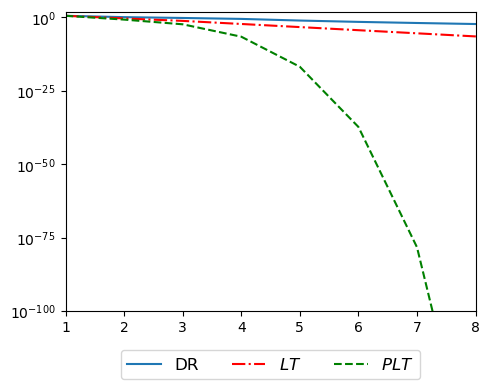

In [33]:
# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1)+1), log_norms_set1,  label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), log_norms_set2,  label='$LT$',  linestyle='-.', color='red')
plt.plot(range(1, len(log_norms_set3) + 1), log_norms_set3,  label='$PLT$', color='green', linestyle= '--')
plt.grid(False)
plt.ylim(-100,2)
plt.xlim(1, 8)

# Set y-ticks as powers of 10
ax = plt.gca()
ax.set_yticks([-100, -75, -50, -25, 0])
ax.set_yticklabels([r'$10^{-100}$', r'$10^{-75}$', r'$10^{-50}$', r'$10^{-25}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=12
)

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('B,A, bound psd and s1, n=10.pdf', bbox_inches='tight')
plt.show()

Setting 3

In [34]:
precision=500
set_precision(precision)

def project_onto_A(A, tol=None):
    # Eigendecomposition (assumes A is Hermitian / symmetric)
    Q, lam = eigh_mp(A)

    # Tolerances (use exact mpf types)
    if tol is None:
        tol = mp.mpf('0')              # treat exact zeros as semidefinite
    tol_im = mp.mpf(f'1e-{mp.dps}')  # imag-part tolerance for sanity check

    # Real-part extraction with sanity check
    lam_real = [mp.mpf(mp.re(lv)) if abs(mp.im(lv)) < tol_im
                else (_ for _ in ()).throw(ValueError(f"eig has non-negligible imag {lv}"))
                for lv in lam]

    # If any eigenvalue is <= tol, do standard PSD clipping; else (PD) push to boundary
    if any(lv <= tol for lv in lam_real):
        lam_mod = [lv if lv > tol else mp.mpf('0') for lv in lam_real]
    else:
        # Already PD: zero the smallest eigenvalue (force rank drop)
        k_min = min(range(len(lam_real)), key=lambda i: lam_real[i])
        lam_mod = lam_real[:]
        lam_mod[k_min] = mp.mpf('0')
    # Reassemble
    D = matrix(len(lam_mod))
    for i, v in enumerate(lam_mod):
        D[i, i] = v

    # If A is real-symmetric, Q.T is fine; for complex Hermitian, use Q.conjugate().T
    return Q * D * Q.T

def project_onto_B(A):
    S = symmetrize(A)
    S[0, 0] = mp.mpf('1')
    return S

def calculate_log_norms(iterates, threshold=None):
    """
    High-precision: return [ log10(||x_i - x_*||_F) ] for i = 1..k-1.
    Each entry is mp.mpf (or None if the norm is zero or below cutoff).
    threshold: cutoff on log10(norm); default ~half of working digits.
    """
    if len(iterates) < 2:
        return []

    if threshold is None:
        threshold = mp.mpf(-(mp.dps // 2))  # precision-aware cutoff

    xk = iterates[-1]
    out = []
    for xi in iterates[:-1]:
        n = fro_norm(xi - xk)  # mp.mpf >= 0
        if n == mp.mpf('0'):
            out.append(None)
        else:
            lg10 = mp.log10(n)  # exact base-10, no division by ln(10)
            out.append(lg10 if lg10 > threshold else None)
    return out




master_seed = 1  # change to get a different reproducible stream
rng = random.Random(master_seed)

exp = 1000
n   = 10
M_list = []
for _ in range(exp):
    A = rand_matrix_fixed(n, rng, a=-1,b=1, bits=128)
    M = symmetrize(A)
    M_list.append(M)
x0=M_list[0]
# can get quadratic lt linear plt if n=10, a=-4,b=4 bound psd and s11

runs = 10
iterates_set1 = douglas_rachford(x0, runs, True)[3]
iterates_set2 = lyapunov_surrogate(x0, runs, True)[3]
iterates_set3 = projected_lyapunov_surrogate(x0, runs, True)[3]

log_norms_set1 = calculate_log_norms(iterates_set1)
log_norms_set2 = calculate_log_norms(iterates_set2)
log_norms_set3 = calculate_log_norms(iterates_set3)


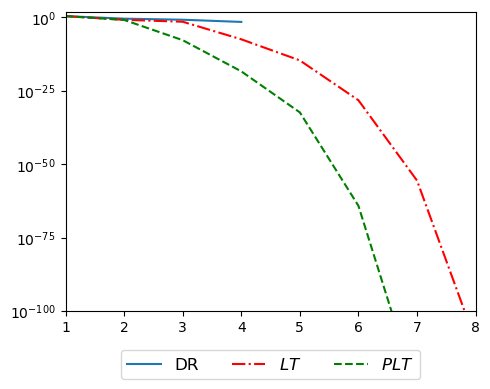

In [35]:
# Plotting
plt.figure(figsize=(5, 4))
plt.plot(range(1, len(log_norms_set1)+1), log_norms_set1,  label='DR')
plt.plot(range(1, len(log_norms_set2) + 1), log_norms_set2,  label='$LT$',  linestyle='-.', color='red')
plt.plot(range(1, len(log_norms_set3) + 1), log_norms_set3,  label='$PLT$', color='green', linestyle= '--')
plt.grid(False)
plt.ylim(-100,2)
plt.xlim(1, 8)

# Set y-ticks as powers of 10
ax = plt.gca()
ax.set_yticks([-100, -75, -50, -25, 0])
ax.set_yticklabels([r'$10^{-100}$', r'$10^{-75}$', r'$10^{-50}$', r'$10^{-25}$', r'$10^{0}$'])

#plt.xlabel('Iteration')
#plt.ylabel(r'$\log \|x_k - \bar{x}\|$')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=12
)

plt.tight_layout()  # Adjust layout to make space for legend
plt.savefig('B,A, bound psd and s11, n=10.pdf', bbox_inches='tight')
plt.show()